# Simulating Outcomes

Venture capital returns on companies are very skewed as compared to other asset classes. A few good investments make up the majority of the return, while most other companies more often than not do not actually cover their investment. The graph below is from outlier ventures and depicts the return ranges for portfolio companies. We will investigate a few different ways of converting this into a probability distribution as well as how to conduct monte carlo simulations to get a rough idea for some scenarios that might happen.

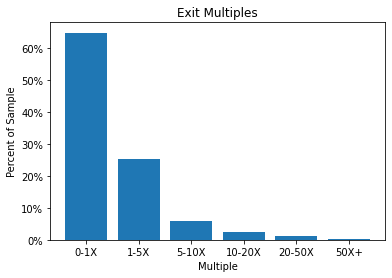

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

#Labels of the return multiples
labels = ['0-1X', '1-5X','5-10X', '10-20X', '20-50X', '50X+']

#The actual percent of investments that fell in this range
actual = [.648, .253, .059, .025, .011, .004]

#Plot the bar graph
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(labels, actual)

#Format the graph
ax.set_title("Exit Multiples")
ax.set_xlabel("Multiple")
ax.set_ylabel("Percent of Sample")

#Setting the major_formatter to the PercentFormatter changes the ticks to be percent
#Using 1 as the argument says that percents will be passed as decimals
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

We can get a cummulative distribution function to find the probability that a value is less than or equal to a certain threshold. If we use numpy's cumsum function we find at each point the total amount of probability covered. Notice how cumsum works first.

In [2]:
import numpy as np
print(np.cumsum(actual))

[0.648 0.901 0.96  0.985 0.996 1.   ]


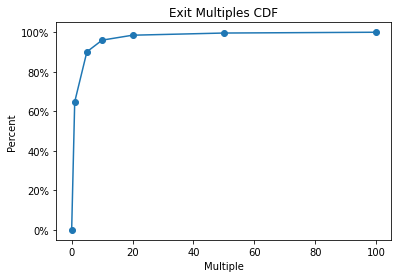

In [3]:
#Create the CDF, starting with 0 since it is our lower bound and there is probability 0% of multiples lower than it
actual_cdf = [0]+list(np.cumsum(actual))

#We will give an aribitrary maximum multiple of 100
multiples = [0,1,5,10,20,50,100]

#Plot the CDF with markers for each threshold
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(multiples, actual_cdf,marker='o')
ax.set_xlabel("Multiple")
ax.set_ylabel("Percent")
ax.set_title("Exit Multiples CDF")
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

## Interpolation

For replicating the probability distribution, interpolation is the easiest method to implement. Essentially, we will simply assume that between each point there is line connecting the cummulative distribution function. With our prediction function we can interpolate, given any point, what we think the CDF will be. 

Recall that linspace gives you n equally spaced points between a start and end point. For example, 1001 points between 0 and 100 is:

In [4]:
#Create the equally spaced points
print(np.linspace(0,100,1001, endpoint=True))

[  0.    0.1   0.2 ...  99.8  99.9 100. ]


### Using Scipy's Interpolation

Scipy has an interpolation function which works by first taking values of X and Y, and then can be called for prediction. First you define the interpolation function, then you use it as though it were a regular function to predict values.

In [5]:
from scipy.interpolate import interp1d

#Create an object for prediction by giving the X and Y values
pred_func = interp1d(multiples, actual_cdf)

#Predict the cdf at all points based on this
x = np.linspace(0,100,1001, endpoint=True)
pred = pred_func(x)

The predicted line will hit exactly at the points that we give it, so there is an exact replication of the CDF. This is good in one sense, we know that our CDF at points we know won't be different. It is bad in another sense though, because we might not expect the line to be linear.

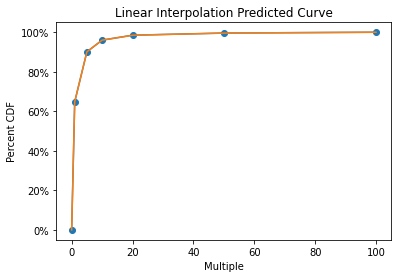

In [6]:
#Plot the line
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(multiples, actual_cdf,marker='o')
ax.plot(x, pred)
ax.set_xlabel("Multiple")
ax.set_ylabel("Percent CDF")
ax.set_title("Linear Interpolation Predicted Curve")
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

In [7]:
#You can also predict individual points
x0 = 13
print(pred_func(x0))

0.9675


In mathematical notation, we can represent what linear interpolation really does so that we can build a function to do the inverse of it. Given a point x, first we need to find $x_{L}$ and $x_{U}$ which are the x points that are closest on the left and right (lower and upper bounds). These x points have their associated y points of $y_{L}$ and $y_{U}$. Now, essentially what we need to do is to draw a line between these two points, and then find where our x point would land. Mathematically, we get:

$$ y = y_{L} + (y_{U} - y_{L}) * \frac{x-x_{L}}{x_{U}-x_{L}}$$

To create a function which takes a CDF value and returns the associated y value, we follow these steps:

1. If the value is in points we know already, just return that x value.
2. If not, iterate through all the y values until we find the first value which is greater than our value we passed as an argument.
3. Apply the formula to get back what the x value should be.

In [8]:
#Make our own inversion function
def inverse_transform(cdf_val, actual_cdf, multiples):
    #If the value is in the cdf already, return the value associated with it
    if cdf_val in actual_cdf:
        return multiples[actual_cdf.index(cdf_val)]
    else:
        #Iterate through the y values until we find the first point which is greater than the value passed as an argument
        i = 0
        while cdf_val > actual_cdf[i]:
            i += 1
        #Compute the value
        a = (cdf_val - actual_cdf[i-1]) / (actual_cdf[i] - actual_cdf[i-1] )
        b = (multiples[i]-multiples[i-1])
        c = multiples[i-1]

        return b*a+c

print(inverse_transform(.9675, actual_cdf, multiples))

13.000000000000021


## Randomness for Simulation

We will simulate random events by pulling randomly from the uniform distribution 0 to 1, and then converting this into multiples. By doing this, we are able to get a random sample which fits the interpolated distribution. One note, I set the seed in the first line to make it so that these experiments can be replicated. When we set the seed, it makes it so the random numbers that come out are the same each time. Different seeds will yield different random numbers, but using the same seed (10), you should be able to get the same numbers as I do for the sake of replicating.

In [9]:
#Set the seed
np.random.seed(10)

#Pull a random value
cdf_val = np.random.uniform(0,1)

#Inverse the transformation to get the random multiple of he company, in this case 2.95
print(inverse_transform(cdf_val, actual_cdf, multiples))

2.9497334903833354


What about simulating 25 companies at random? If you pass in a third argument, it will return that number of random samples. The output to get 25 random samples for example....

In [10]:
#Set the seed
np.random.seed(0)

#Get the random values
cdf_vals = np.random.uniform(0,1, 25)

print(cdf_vals)

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152 0.79172504 0.52889492
 0.56804456 0.92559664 0.07103606 0.0871293  0.0202184  0.83261985
 0.77815675 0.87001215 0.97861834 0.79915856 0.46147936 0.78052918
 0.11827443]


Let's do the inverse transformation to find 25 random multiples.

In [11]:
#Set the seed
np.random.seed(0)

#Compute the random multiples
cdf_vals = np.random.uniform(0,1, 25)
valuations = [inverse_transform(x, actual_cdf, multiples) for x in cdf_vals]
print(valuations)
print()

#Find the mean of the multiples
print(np.mean(valuations))

[0.8469344196409332, 2.0622824722912165, 0.9301903951722899, 0.8408691095631124, 0.6537882705847294, 0.9967501744855803, 0.6752889062695872, 4.854118589439996, 11.465104200411725, 0.5917307389286692, 3.27233261790774, 0.8161958638162106, 0.876611976996809, 7.08446087225941, 0.10962354660167738, 0.13445879583571096, 0.031201230617786603, 3.9188908387025765, 3.0578142442664107, 4.510073490068287, 17.447336893105607, 3.389858722794049, 0.7121595096495862, 3.0953229452404023, 0.18252226214341546]

2.902236843471741


## Computing Annualized Return

Assuming an equal weighting between the 25 investments, and a time horizon of 8 years, we can compute the annualized return of this random sample. Recall that CAGR (compounded annualized growth rate) can be found from the holding period return like so:

$ CAGR = (1 + HPR)^{\frac{1}{t}} - 1$

where

$ CAGR = \text{Compounded Annualized Growth Rate} $

$ HPR = \text{Holding Period Return} $

$ t = \text{Number of Years} $


Since the mean exit value is equal to $1 + HPR$, the following will give us the annualized return on this set of 25 companies which is 14.2% a year. Not bad!

In [12]:
#Compute CAGR
print(np.mean(valuations) ** (1/8) - 1)

0.14246158618538907


With all of this code that we have written, we are ready to simulate 10,000 simulations of holding 25 companies from this distribution.

In [13]:
#Set the seed
np.random.seed(0)

#Set a blank list to record each return for the simulation
returns = []

#Iterate through 100,000 simulations
for _ in range(100000):
    #Randomly pull 25 values from the uniform distribution
    cdf_vals = np.random.uniform(0,1, 25)
    #Convert it into valuations
    valuations = [inverse_transform(x, actual_cdf, multiples) for x in cdf_vals]
    #Find the annualized return and append it to the list
    returns.append(np.mean(valuations) ** (1/8) - 1)

In [14]:
#Compute the mean and standard deviation
print(np.mean(returns))
print(np.std(returns))

0.1127546856779015
0.06443560939513421


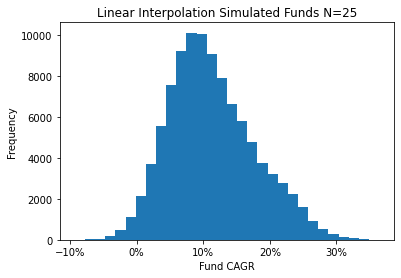

In [15]:
#Plot the histogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(returns, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Linear Interpolation Simulated Funds N=25")
plt.show()

0.09822101908926366
0.09099641235554093


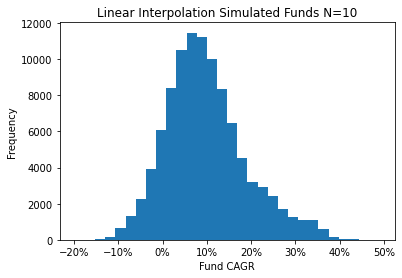

In [16]:
#Repeat with just 10 investments
np.random.seed(0)
returns2 = []
for _ in range(100000):
    cdf_vals = np.random.uniform(0,1, 10)
    valuations = [inverse_transform(x, actual_cdf, multiples) for x in cdf_vals]
    returns2.append(np.mean(valuations) ** (1/8) - 1)
    
print(np.mean(returns2))
print(np.std(returns2))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(returns2, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Linear Interpolation Simulated Funds N=10")
plt.show()

0.11889495517374847
0.048139217907553704


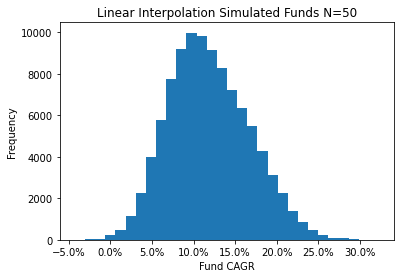

In [17]:
#Repeat with 50 investments
np.random.seed(0)
returns3 = []
for _ in range(100000):
    cdf_vals = np.random.uniform(0,1, 50)
    valuations = [inverse_transform(x, actual_cdf, multiples) for x in cdf_vals]
    returns3.append(np.mean(valuations) ** (1/8) - 1)
    
print(np.mean(returns3))
print(np.std(returns3))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(returns3, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Linear Interpolation Simulated Funds N=50")
plt.show()

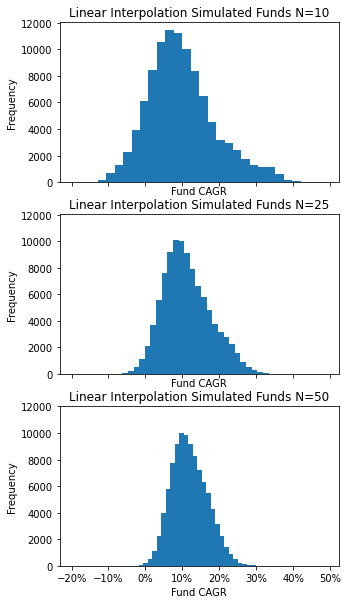

In [18]:
#Plot the 3 together
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True,figsize=(5,10))

ax = axs[0]
ax.hist(returns2, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Linear Interpolation Simulated Funds N=10")

ax = axs[1]
ax.hist(returns, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Linear Interpolation Simulated Funds N=25")

ax = axs[2]
ax.hist(returns3, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Linear Interpolation Simulated Funds N=50")
plt.show()

## Exponential Distribution

The exponential distribution has the following probability distribution function:

$ \lambda e^{-\lambda x} \text{ for x >= 0}$

The cummulative distribution is equal to:

$ P(X <= x) = 1 - e^{-\lambda x}$


In [19]:
#Compare three different values of lambda for a distribution
X = np.linspace(0,5,1001, endpoint=True)

lambda1 = 1
lambda2 = .5
lambda3 = 2

pdf1 = lambda1 * np.exp(X * -lambda1)
pdf2 = lambda2 * np.exp(X * -lambda2)
pdf3 = lambda3 * np.exp(X * -lambda3)

cdf1 = 1 - np.exp(X * -lambda1)
cdf2 = 1 - np.exp(X * -lambda2)
cdf3 = 1 - np.exp(X * -lambda3)

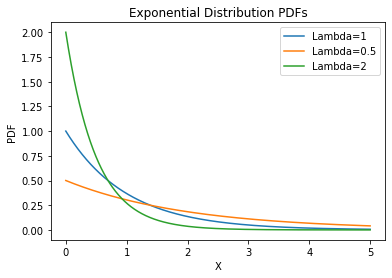

In [20]:
#Plot the PDFs
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(X, pdf1)
ax.plot(X, pdf2)
ax.plot(X, pdf3)
ax.set_xlabel("X")
ax.set_ylabel("PDF")
ax.set_title("Exponential Distribution PDFs")
plt.legend(["Lambda={}".format(x) for x in [lambda1, lambda2, lambda3]])
plt.show()

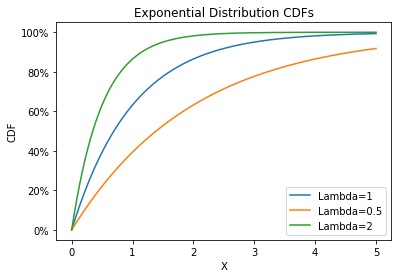

In [21]:
#Plot the CDFs
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(X, cdf1)
ax.plot(X, cdf2)
ax.plot(X, cdf3)
ax.set_xlabel("X")
ax.set_ylabel("CDF")
ax.set_title("Exponential Distribution CDFs")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(["Lambda={}".format(x) for x in [lambda1, lambda2, lambda3]])
plt.show()

Taking the points which we already have from the actual CDF curve, we can try to find what value of lambda would be implied. Let's see an example first to understand the intuition. Say that we know the CDF at X=1.5 is .9502, what would the implied lambda be if it were coming from an exponential distribution?

First, set up the problem:

$ P(X <= x) = 1 - e^{-\lambda X}$

$ P(X <= 1.5) = 1 - e^{- 1.5\lambda}$

$ .9502  = 1 - e^{- 1.5\lambda}$

$ .0498  =  e^{- 1.5\lambda}$

$ ln(.0498)  =  ln(e^{- 1.5\lambda})$

$ -3  =  - 1.5\lambda$

$ \lambda = 2$


If we want to generalize this to finding it for problems:

$$ \lambda = \frac{-ln(1 - CDF)}{x} $$


For this analysis, we don't want to analyze the end values (the value of 0 or the value of 100) so we are going to index 1:-1 meaning everything except the ends.

In [22]:
#Go through all the points we have
for mult, cdf in zip(multiples[1:-1], actual_cdf[1:-1]):
    #Calculate what the implied lambda would have to be
    implied_lambda = -np.log(1-cdf)/mult
    #Print the information
    print("x: {}, CDF: {}, lambda: {}".format(mult, cdf, implied_lambda))

x: 1, CDF: 0.648, lambda: 1.04412410338404
x: 5, CDF: 0.901, lambda: 0.4625270857695095
x: 10, CDF: 0.96, lambda: 0.32188758248682
x: 20, CDF: 0.985, lambda: 0.2099852538939963
x: 50, CDF: 0.996, lambda: 0.1104292183572449


In [23]:
#Do a quick check to make sure the formula works with x: 5, CDF: 0.901, lambda: 0.4625270857695095
print(1-np.exp(-0.4625270857695095 * 5))

0.901


The way taht the implied lambda keeps going down allows us to see that the exponential distribution as it is right now will not be useful. However, something we can do is a log transformation. A log transformation can be used to modify the data in a way that makes it more predictable, and then we can transform it back after the prediction is done. Look at how the curve looks if we change the x values to be ln(x) instead of x. We will create the log transformed x variables by doing $ln(1+x)$.

In [24]:
#Do the transformation 
log_multiples = np.log([x+1 for x in multiples])
print(log_multiples)

[0.         0.69314718 1.79175947 2.39789527 3.04452244 3.93182563
 4.61512052]


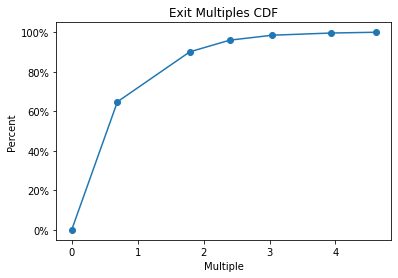

In [25]:
#Now it looks much more like an exponential distribution
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(log_multiples, actual_cdf,marker='o')
ax.set_xlabel("Multiple")
ax.set_ylabel("Percent")
ax.set_title("Exit Multiples CDF")
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

The formula is modified to be the following with the log transformation:

$$ \lambda = \frac{-ln(1 - CDF)}{ln(x+1)} $$


In [26]:
#If we transform the x variable with a log transformation, we get much closer values of lambda
for mult, cdf in zip(multiples[1:-1], actual_cdf[1:-1]):
    log_mult = np.log(mult+1)
    implied_lambda = -np.log(1-cdf)/log_mult
    print("x: {}, CDF: {}, lambda: {}".format(mult, cdf, implied_lambda))

x: 1, CDF: 0.648, lambda: 1.50635266602479
x: 5, CDF: 0.901, lambda: 1.2907064081787172
x: 10, CDF: 0.96, lambda: 1.3423754829424788
x: 20, CDF: 0.985, lambda: 1.3794298330152248
x: 50, CDF: 0.996, lambda: 1.404299537575494


Let's use a simple heuristic to decide on the value to use. To make things simple, we are going to collect the average implied lambdas and then take the average of this.

In [27]:
lambdas = []
for mult, cdf in zip(multiples[1:-1], actual_cdf[1:-1]):
    lambdas.append(-np.log(1-cdf)/np.log(mult+1))
print(lambdas)
print()
lambda_log = np.mean(lambdas)
print(lambda_log)

[1.50635266602479, 1.2907064081787172, 1.3423754829424788, 1.3794298330152248, 1.404299537575494]

1.384632785547341


Now, we can predict the cdf for each multiple, but remember that we need to do a log transform first!

In [28]:
cdf_pred = [1-np.exp(-lambda_log * np.log(x+1)) for x in  multiples]
print(cdf_pred)

[0.0, 0.6170130300555561, 0.9163345277827373, 0.96385455752812, 0.9852357355713208, 0.9956784220539311, 0.9983221585734632]


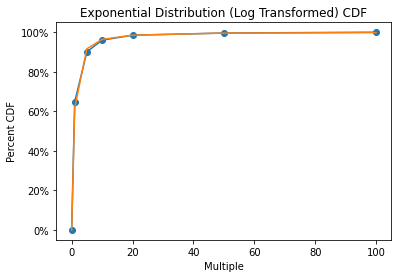

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(multiples, actual_cdf,marker='o')
ax.plot(multiples, cdf_pred)
ax.set_xlabel("Multiple")
ax.set_ylabel("Percent CDF")
ax.set_title("Exponential Distribution (Log Transformed) CDF")
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

You will notice that it fits the curve very well! The next thing we want to do is create a function that does the inverse, so that given a value in the CDF, we can get the value for x. The equation that we have been using is:

$ \lambda = \frac{-ln(1 - CDF)}{ln(x+1)} $

which we can re-arrange to be:

$ ln(x+1) = \frac{-ln(1 - CDF)}{\lambda } $

Taking the exponential of each side....

$ e^{ln(x+1)} = e^{\frac{-ln(1 - CDF)}{\lambda }} $

$ x+1 = e^{\frac{-ln(1 - CDF)}{\lambda }} $

$ x = e^{\frac{-ln(1 - CDF)}{\lambda }} -1$

This is our inverse transformation function!

In [30]:
#Build the function and try it out with a cdf value
cdf_val = 0.96385455752812
def inverse_transform(cdf_val, lambda_log):
    return np.exp(np.log(-(cdf_val-1)) / -lambda_log) - 1
inverse_transform(cdf_val, lambda_log)

10.000000000000002

We can use this to now simulate random draws like before!

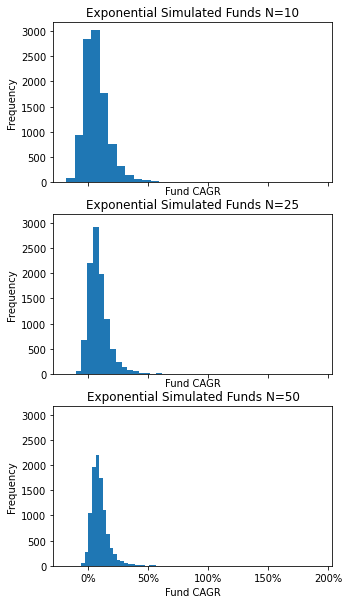

In [31]:
np.random.seed(0)
returns1 = []
returns2 = []
returns3 = []

for _ in range(10000):
    cdf_vals = np.random.uniform(0,1, 10)
    valuations = [inverse_transform(x, lambda_log) for x in cdf_vals]
    returns1.append(np.mean(valuations) ** (1/8) - 1)
    
    cdf_vals = np.random.uniform(0,1, 25)
    valuations = [inverse_transform(x, lambda_log) for x in cdf_vals]
    returns2.append(np.mean(valuations) ** (1/8) - 1)
    
    cdf_vals = np.random.uniform(0,1, 50)
    valuations = [inverse_transform(x, lambda_log) for x in cdf_vals]
    returns3.append(np.mean(valuations) ** (1/8) - 1)
    
#Plot the 3 together
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True,figsize=(5,10))

ax = axs[0]
ax.hist(returns1, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=10")

ax = axs[1]
ax.hist(returns2, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=25")

ax = axs[2]
ax.hist(returns3, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=50")
plt.show()

In [32]:
#Get the stats for the simulations
table = pd.DataFrame([[np.mean(r), np.std(r)] for r in [returns1, returns2, returns3]],
            index=['N=10', 'N=25', 'N=50'],
            columns=['Mean', 'STD'])
print(table)

          Mean       STD
N=10  0.068759  0.105827
N=25  0.089040  0.089313
N=50  0.097952  0.072393


## Function Minimization Basics

If we have a function we would like to minimize, we can use the minimize function from scipy.optimize. While it is very powerful, you need to be careful to understand that it has limitations and works best with smooth functions. For the purpose that we are going to use it for, it does a great job, but be aware that it may not always be the best fit. If there are multiple local minimum points then it can get caught on one of these as opposed to the global minimum, for example.

The minimize function has many different solvers that could be used. Because this is not a course in optimization we will not go through them and instead use the default. The main idea is similar between all the solvers.... to iteratively reduce the error by shifting parameters until we can't reduce it anymore. Let's begin with defining a basic function that we want to try minimizing.

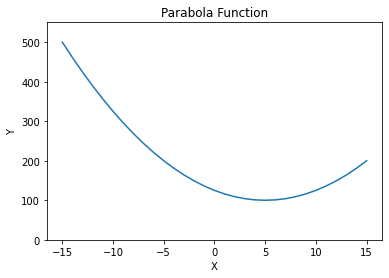

In [33]:
#Define a basic parabola function
def parabola(x):
    y = (x-5) ** 2 + 100
    return y

#Space out 21 points between -15 and 15
X = np.linspace(-15,15,31)

#Get the Y values based on the parabola function
Y = [parabola(x) for x in X]

#Plot
plt.plot(X, Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Parabola Function")
plt.ylim([0,550])
plt.show()

In [34]:
#Start with a naive guess of the x point that minimizes the function of 0
x0 = 0
y0 = parabola(x0)
print(x0, y0)

0 125


In [35]:
#Notice that one to the right decreases the function, while one to the left increases it
#When we run the optimization, it will move to the right 
print(parabola(x0+1))
print(parabola(x0-1))

116
136


### The minimzie function

The minimize function will take two arguments:
1. The function which we want to minimize
2. The starting value for x, the value that needs to be changed to find the minimum

The output from the function will be a dictionary full of a lot of different information including the number of iterations run as well as the value of x that is the minimum.

In [36]:
#Run the function
from scipy.optimize import minimize

print(minimize(parabola, x0))

      fun: 100.00000000000003
 hess_inv: array([[0.49999995]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([4.99999982])


The key 'x' gives us back what we are looking for, the optimal value for x. Notice it comes back as a list, we will need to grab the first index to get the actual value. It comes back as a list because our input does not necessarily have to be a single variable.

In [37]:
print(minimize(parabola, x0)['x'])

[4.99999982]


Plotting the point confirms that we have found the minimum.

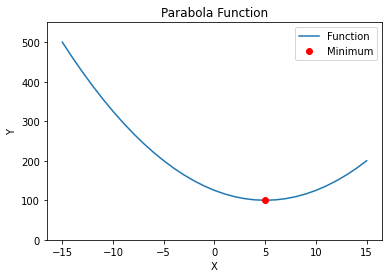

In [38]:
#Get the minimum point
x_opt = minimize(parabola, x0)['x'][0]
y_opt = parabola(x_opt)

#Add it to plot
plt.plot(X, Y)
plt.plot(x_opt, y_opt, 'ro')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Parabola Function")
plt.ylim([0,550])
plt.legend(['Function', 'Minimum'])
plt.show()

## Extending to Multiple Dimensions

The minimization function can also handle multiple dimensions. We just will need to define the function in a way that it takes an argument of a list of these x variables. Let's define a 2D function below. The variable x will be a list with two values. Let's define the function, then after that we need to quickly cover something else that will aid us in solving the problem.

In [39]:
#Define the function
def func2D(x):
    return (x[0] - 5) ** 2 * (x[1] - 5) ** 2 + 500

### The product function from itertools

A very handy function from itertools is the product function. By using this, we can find all combinations of lists. For example, if we wanted all combinations of ['A', 'B', 'C'] and ['1', '2', '3'], the following code below would produce it. The format for this is to call product(*[l1, l2]) where l1 and l2 are the two lists to get the product of.

In [40]:
from itertools import product

#Define the lists
l1 = ['A', 'B', 'C']
l2 = ['1', '2', '3']

#Get the iterator
combos = product(*[l1,l2])

print(combos)

Iterators can be used by calling \_\_next__() to get out the next value. For example, below we get the first combination followed by the second combination.

In [41]:
#To get the next combo, you can call __next__()
print(combos.__next__())

('A', '1')


In [42]:
#If you call again, it will be the one after it
print(combos.__next__())

('A', '2')


It could also be simply converted to a list.

In [43]:
#Or just transform it into a list
combos = product(*[l1,l2])
combos = list(combos)

print(combos)

[('A', '1'), ('A', '2'), ('A', '3'), ('B', '1'), ('B', '2'), ('B', '3'), ('C', '1'), ('C', '2'), ('C', '3')]


Now that we know how to get all the possible combinations, what if we find all combinations of the X values we defined before. We will use the same values for the X1 and X2 variables. Also, we will transform it into a pandas dataframe.

In [44]:
#Get combos
combos = product(*[X,X])
combos = list(combos)

#Convert to a dataframe
df = pd.DataFrame(combos, columns = ['X1', 'X2'])

print(df)

       X1    X2
0   -15.0 -15.0
1   -15.0 -14.0
2   -15.0 -13.0
3   -15.0 -12.0
4   -15.0 -11.0
..    ...   ...
956  15.0  11.0
957  15.0  12.0
958  15.0  13.0
959  15.0  14.0
960  15.0  15.0

[961 rows x 2 columns]


In [45]:
#Use the apply function to find the values at each combination
df["Y"] = df.apply(func2D, axis=1)
print(df)

       X1    X2         Y
0   -15.0 -15.0  160500.0
1   -15.0 -14.0  144900.0
2   -15.0 -13.0  130100.0
3   -15.0 -12.0  116100.0
4   -15.0 -11.0  102900.0
..    ...   ...       ...
956  15.0  11.0    4100.0
957  15.0  12.0    5400.0
958  15.0  13.0    6900.0
959  15.0  14.0    8600.0
960  15.0  15.0   10500.0

[961 rows x 3 columns]


Now that we have a general outline of what the function looks like in three dimensions, we can plot it below.

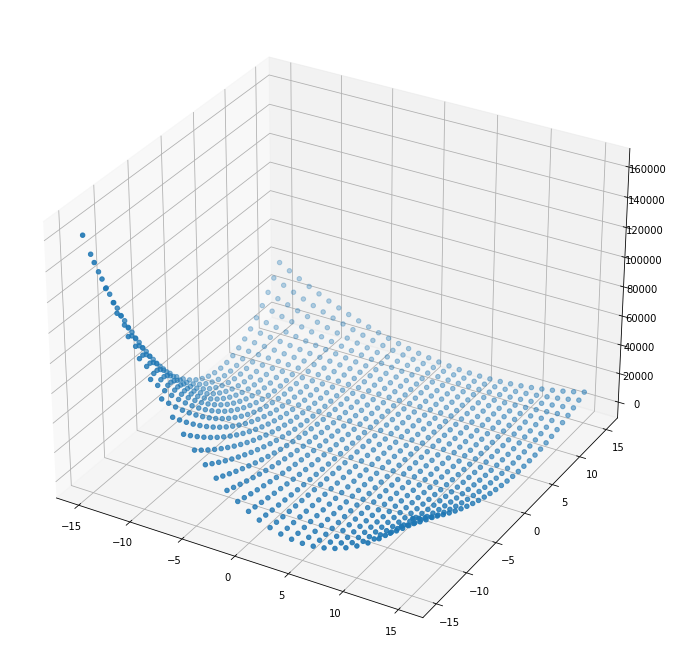

In [46]:
#Create a 3d plot figure
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

#Add a scatter plot of all the 3d points
ax.scatter(df['X1'], df['X2'], df['Y'])
plt.show()

With our optimization, we are going to pass in two starting values to begin. It will simply be the origin, (0, 0) and what we will get back is the most optimal point.

In [47]:
#Now we can give an input of two starting values
x0 = [0,0]
print(minimize(func2D, x0))
print()
print()

#The output is going to be two optimal points
x1_opt, x2_opt = minimize(func2D, x0)['x']
y_opt = func2D([x1_opt, x2_opt])
print(x1_opt)
print(x2_opt)
print(y_opt)

      fun: 500.00000006039045
 hess_inv: array([[135.48482389, 134.48482389],
       [134.48482389, 135.48482389]])
      jac: array([-7.62939453e-06, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 21
     njev: 22
   status: 0
  success: True
        x: array([4.98432376, 4.98432376])


4.984323755729247
4.984323755729236
500.00000006039045


Adding this point into the graph we see visually that it is in fact the minimum.

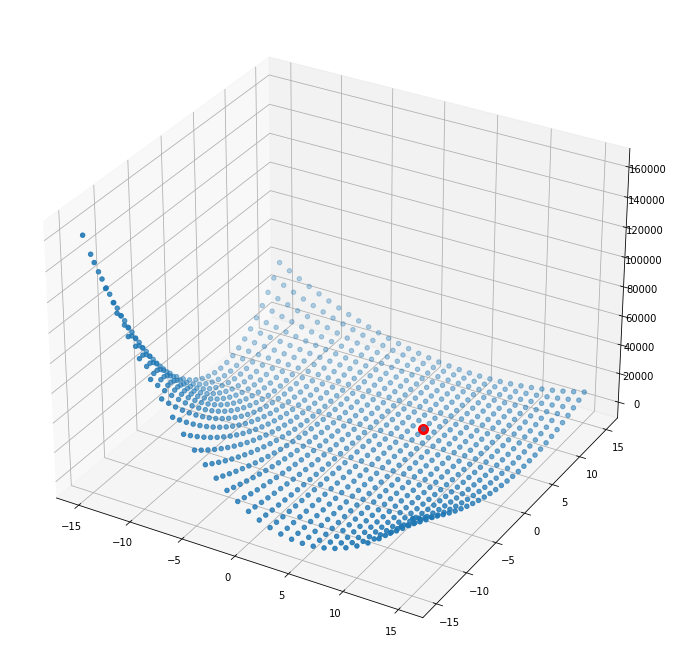

In [48]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

#Add a scatter plot of all the 3d points
ax.scatter(df['X1'], df['X2'], df['Y'])

ax.scatter(x1_opt, x2_opt, y_opt, color='red', s=100)
plt.show()

## Allowing Arguments in the Minimization

It would not be quite so convient if you had to have every function only take one variable as an input. Thankfully, we can very easily pass any additional arguments in the optimization. First, let's see how the 1D parabola function could be modified with a parameter a.

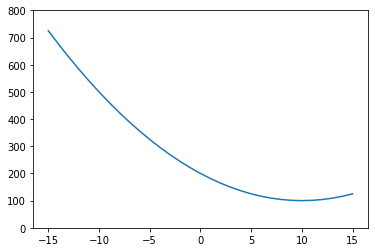

In [49]:
#Modified function
def parabola_modified(x, a):
    y = (x-5*a) ** 2 + 100
    return y
X = np.linspace(-15,15,31)
Y = [parabola_modified(x, 2) for x in X]

plt.plot(X, Y)
plt.ylim([0,800])
plt.show()

To pass in arguments, simply give the minimzation argument args a tuple with all values to be passed in.

In [50]:
#Pass in the argument 2 for a
x0 = 0 
print(minimize(parabola_modified, x0, args=(2)))

      fun: 100.00000000000023
 hess_inv: array([[0.49999992]])
      jac: array([-9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([9.99999953])


## Fitting the Curve Based on Error

Two ways to look at it:

1. Minimize the overall error for the CDF curve.
2. Minimize the difference for each group's percent of companies in either absolute or relative error terms.

### Minimizing the CDF Curve

If we chose to minimize the CDF curve, we would have our $Y$ variable be the actual value of the CDF at each x point and our $\hat{Y}$ be the predicted variable. With that in mind, we could minimize the sum of the squared residuals (differences) with the following form:

$ \Sigma(Y_{i} - \hat{Y}_{i})^2 $

In [51]:
#Find the difference between the predicted and actual cdf curves
#Get the sum of squared errors
print(cdf_pred - np.array(actual_cdf))
print(((cdf_pred - np.array(actual_cdf)) ** 2).sum())

[ 0.         -0.03098697  0.01533453  0.00385456  0.00023574 -0.00032158
 -0.00167784]
0.001213171797882587


Converting this to a function and plotting the error will help us in seeing what the best option for lambda might be.

In [52]:
#Build a function to find the error
def find_error(lambda_log, actual_cdf, multiples):
    lambda_log = lambda_log[0]
    cdf_pred = [1-np.exp(-lambda_log * np.log(x+1)) for x in  multiples]
    return ((cdf_pred - np.array(actual_cdf)) ** 2).sum()
print(find_error([lambda_log], actual_cdf, multiples))

0.001213171797882587


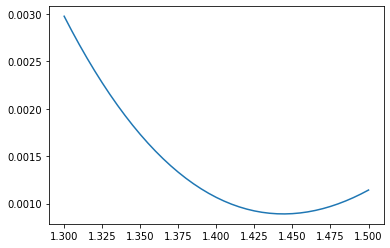

In [53]:
#Plot the error function
X = np.arange(1.3,1.505, .005)
err = []
for lambda_log in X:
    err.append(find_error([lambda_log], actual_cdf, multiples))
plt.plot(X, err)
plt.show()

In this case, 1.44 is the optimal lambda.

1.4440311069061806


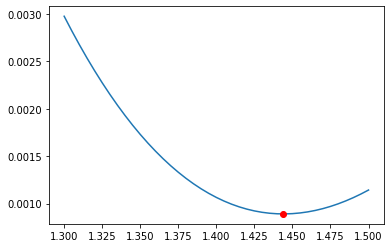

In [54]:
#The optimal lambda comes out to 1.44
lambda_log_opt = minimize(find_error, [1.4], args=(actual_cdf, multiples))['x'][0]
print(lambda_log_opt)

plt.plot(X, err)
plt.plot(lambda_log_opt, find_error([lambda_log_opt], actual_cdf, multiples), 'ro')
plt.show()

Simulations given this optimal lambda give us some ideas of possible paths that the investments could take.

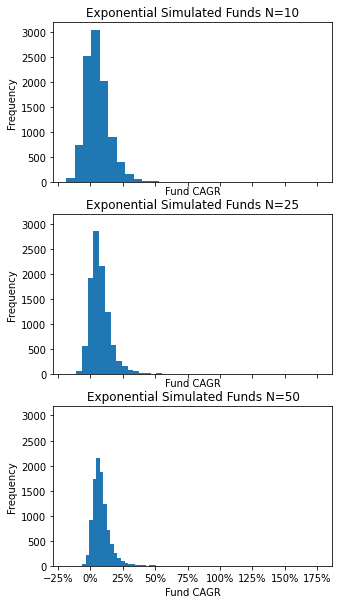

In [55]:
np.random.seed(0)
returns1 = []
returns2 = []
returns3 = []

for _ in range(10000):
    cdf_vals = np.random.uniform(0,1, 10)
    valuations = [inverse_transform(x, lambda_log_opt) for x in cdf_vals]
    returns1.append(np.mean(valuations) ** (1/8) - 1)
    
    cdf_vals = np.random.uniform(0,1, 25)
    valuations = [inverse_transform(x, lambda_log_opt) for x in cdf_vals]
    returns2.append(np.mean(valuations) ** (1/8) - 1)
    
    cdf_vals = np.random.uniform(0,1, 50)
    valuations = [inverse_transform(x, lambda_log_opt) for x in cdf_vals]
    returns3.append(np.mean(valuations) ** (1/8) - 1)
    
#Plot the 3 together
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True,figsize=(5,10))

ax = axs[0]
ax.hist(returns1, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=10")

ax = axs[1]
ax.hist(returns2, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=25")

ax = axs[2]
ax.hist(returns3, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=50")
plt.show()

In [56]:
#Get the stats for the simulations
table = pd.DataFrame([[np.mean(r), np.std(r)] for r in [returns1, returns2, returns3]],
            index=['N=10', 'N=25', 'N=50'],
            columns=['Mean', 'STD'])
print(table)

          Mean       STD
N=10  0.056886  0.100331
N=25  0.075545  0.083401
N=50  0.083574  0.066899


### Minimizing the Buckets

Another way to minimize the difference is to be looking at the differences between "buckets" that we saw from the bar graph in the beginning of this lesson. Doing this will mean that we focus on making sure we get closer to replicating that bar graph, rather than the overall curve. First, we can see how to find the probability that each bucket holds from the actual CDF curve (this will be how we also find the probability for the predicted cdf). We just convert it to a numpy array so that we can directly subtract one from the other and then take all values except the first, subtracted from all values except the last to get the difference.

In [57]:
buckets_actual = np.array(actual_cdf)[1:] - np.array(actual_cdf)[:-1]
print(buckets_actual)

[0.648 0.253 0.059 0.025 0.011 0.004]


Let's try the same thing with our predicted cdf curve to find the buckets.

In [58]:
lambda_log = 1.4
cdf_pred = [1-np.exp(-lambda_log * np.log(x+1)) for x in  multiples]
buckets_pred = np.array(cdf_pred)[1:] - np.array(cdf_pred)[:-1]
print(buckets_pred)

[0.62107086 0.29753592 0.04655546 0.02074835 0.01002122 0.00250523]


### Measuring the Error

There are two ways in which we can think about the error. One of them is to simply do the error as the sum of squared residuals like before:

$ \Sigma (Y_{i} - \hat{Y}_{i})^2 $

One thing to consider is that when we look at the low probability values such as the probability between having a 10-50X multiple, we are not going to weight them very heavily. If we predict that it is 0% probability, the penalty in the error is going to be .004^2 which comes out to be a very small number. Because of this, we might want to weight each error in a way that we describe it as the error relative to the actual value. So if we are off by 50% in a bucket, it counts the same amount. The equation for this would be:

$ \Sigma (\frac{Y_{i} - \hat{Y}_{i}}{Y_{i}})^2 $


In [59]:
#The error with method 1
print(((buckets_pred - buckets_actual) ** 2).sum())

0.0028847620990833157


In [60]:
#The error with method 2
print((((buckets_pred - buckets_actual)/buckets_actual) ** 2).sum())

0.25368970026315674


In [61]:
#We can define a function to do everything as it has been in the past, but with buckets
#as well as an option to do the error in terms of relative error
def find_error_buckets(lambda_log, buckets_actual, multiples, relative=False):
    lambda_log = lambda_log[0]
    cdf_pred = [1-np.exp(-lambda_log * np.log(x+1)) for x in  multiples]
    buckets_pred = np.array(cdf_pred)[1:] - np.array(cdf_pred)[:-1]
    if relative:
        err = (((buckets_pred - buckets_actual)/buckets_actual) ** 2).sum()
    else:
        err = ((buckets_pred - buckets_actual) ** 2).sum()
    return err
print(find_error_buckets([lambda_log], buckets_actual, multiples, relative=False))
print(find_error_buckets([lambda_log], buckets_actual, multiples, relative=True))

0.0028847620990833157
0.25368970026315674


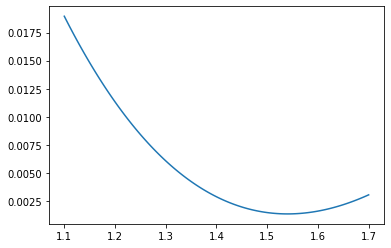

In [62]:
#Plot the error for non-relative buckets
X = np.arange(1.1,1.705, .005)
err = []
for lambda_log in X:
    err.append(find_error_buckets([lambda_log], buckets_actual, multiples, relative=False))
plt.plot(X, err)
plt.show()

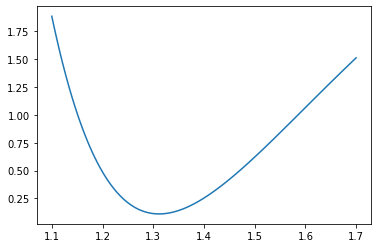

In [63]:
#Plot the error for relative buckets
X = np.arange(1.1,1.705, .005)
err = []
for lambda_log in X:
    err.append(find_error_buckets([lambda_log], buckets_actual, multiples, relative=True))
plt.plot(X, err)
plt.show()

Choosing what to focus on makes a huge difference! When you minimize the relative errors, you weight incorrectly predicting the tails much more heavily.

In [64]:
#Save the first value we found as lambda_log_opt1
lambda_log_opt1 = lambda_log_opt

#Find the other two values
lambda_log_opt2 = minimize(find_error_buckets, [1.4], args=( buckets_actual, multiples,False))['x'][0]
lambda_log_opt3 = minimize(find_error_buckets, [1.4], args=( buckets_actual, multiples,True))['x'][0]

print(lambda_log_opt1)
print(lambda_log_opt2)
print(lambda_log_opt3)

1.4440311069061806
1.5401965955614616
1.3114755373838654


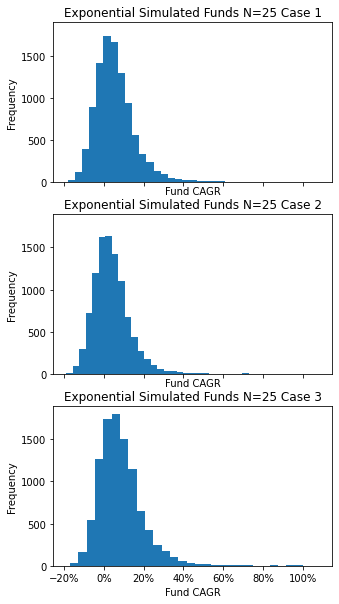

In [65]:
#Finally, let's compare the impact of the three for N=25

np.random.seed(0)
returns1 = []
returns2 = []
returns3 = []

for _ in range(10000):
    cdf_vals = np.random.uniform(0,1, 10)
    
    valuations = [inverse_transform(x, lambda_log_opt1) for x in cdf_vals]
    returns1.append(np.mean(valuations) ** (1/8) - 1)
    
    valuations = [inverse_transform(x, lambda_log_opt2) for x in cdf_vals]
    returns2.append(np.mean(valuations) ** (1/8) - 1)
    
    valuations = [inverse_transform(x, lambda_log_opt3) for x in cdf_vals]
    returns3.append(np.mean(valuations) ** (1/8) - 1)
    
#Plot the 3 together
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True,figsize=(5,10))

ax = axs[0]
ax.hist(returns1, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=25 Case 1")

ax = axs[1]
ax.hist(returns2, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=25 Case 2")

ax = axs[2]
ax.hist(returns3, bins=30)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("Fund CAGR")
ax.set_ylabel("Frequency")
ax.set_title("Exponential Simulated Funds N=25 Case 3")
plt.show()

In [66]:
table = pd.DataFrame([[np.mean(r), np.std(r)] for r in [returns1, returns2, returns3]],
            index=['Case 1', 'Case 2', 'Case 3'],
            columns=['Mean', 'STD'])
print(table)

            Mean       STD
Case 1  0.057472  0.101631
Case 2  0.040114  0.094005
Case 3  0.085658  0.115089


Look how big of a difference the assumptions can make. This is very important to consider when building out your models. As you begin to gather more data, you will find it easier and easier to more accurately model things, but assumptions always can have a large impact!